# Is Your ML Pipeline Fooling You with Chance Portfolio Metrics

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="https://colab.research.google.com/github/adamd1985/quant_research/blob/main/dont_get_fooled_by_chance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![Sea of charts](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/SeaOfChartBanner.png)

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->


## Introduction

With the rise of ML and extraordinary compute applied quantitative research, testing multiple strategies and models at a go is the norm. These pipelines generate, tune, and select models at scale. In this setting of multiple testing, performance metrics must be interpreted as random variables conditioned on a search process, not as standalone estimates that we cherry picked.

This article suggests a Sharpe ratio (SR) inference as statistical governance of model selection pipelines. Governance being: 
1. Model selection under repeated experimentation, statistical control of automated research pipelines, 
2. Performance inference in high-throughput strategy discovery. 
 
Following Bailey and Lopez de Prado (2012) and Bailey and Lopez de Prado (2014), it formalizes the sampling distribution of the Sharpe ratio and show cases two uncertainty-aware evaluation processes, these being the Probabilistic Sharpe Ratio (PSR) and the Deflated Sharpe Ratio (DSR), with synthetic examples.


## Notebook Setup
This notebook uses Python with numpy, pandas, scipy, and matplotlib. A seed assures reproducability.


In [634]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, skewnorm, norm
import matplotlib.pyplot as plt
from pprint import pprint
from numpy.typing import NDArray

import warnings
warnings.filterwarnings("ignore")

INSTALL_DEPS = False
if INSTALL_DEPS:
    # If Kaggle or Colab, you have to manage these. If local, install all
    %pip install numpy
    %pip install pandas
    %pip install scipy


np.random.seed(444)


## The Sharpe Ratio and Its Sampling Distribution

The SR is the benchmark metric used to compare portfolios, strategies and everything trading related. Assume we have a sequence of  returns $r_1,\ldots,r_n$, these are the excess returns from the risk free rate ($r_t - r_f$) plugged into the SR. Our sample SR is defined as the sample mean divided by the sample standard deviation using $𝑛−1$ degrees of freedom:

$$\widehat{\mathrm{SR}} = \frac{\bar r}{s},$$

where

$$\bar r = \frac{1}{n}\sum_{t=1}^n r_t, \qquad s^2 = \frac{1}{n-1}\sum_{t=1}^n (r_t - \bar r)^2.$$

The python function for this is below, we use a default two decade mean risk free rate of $1.5\%$ for simplicity, annualized:

In [635]:
TRADING_DAYS = 252

def compute_sr(returns: np.ndarray[float], rf_rate: float = 0.015) -> float:
    mean_return = np.mean(returns) - (rf_rate / TRADING_DAYS)
    std_return = np.std(returns, ddof=1)
    return mean_return / std_return


Under the assumption of Independent and Identically Distributed (IID) for Normal returns ($\gamma_3 = 0$, $\gamma_4 = 3$), the standard error (SE) of the sample SR is:

$$
\hat\sigma(\widehat{\mathrm{SR}}) =
\sqrt{\frac{1}{n-1}\Bigl(1 + \frac{1}{2}\widehat{\mathrm{SR}}^2\Bigr)}.
$$

The SE shows us that the SR is not a direct property of the strategy, but an attribute of the underlying data, and estimate. Estimated, because Real-world returns aren’t normal. Lo (2002) shows in their paper that the SR estimator is asymptotically normal, and the standard error widens when returns are skewed or fat-tailed:

$$
\hat\sigma(\widehat{\mathrm{SR}}) =
\sqrt{\frac{1}{n-1}\Bigl(
1 + \frac{1}{2}\widehat{\mathrm{SR}}^2
- \gamma_3 \widehat{\mathrm{SR}}
+ \frac{\gamma_4 - 3}{4}\,\widehat{\mathrm{SR}}^2
\Bigr)},
$$

where $\gamma_3$ and $\gamma_4$ are the sample skewness and kurtosis. With that, the usual standardized form is:

$$
\frac{\widehat{\mathrm{SR}} - \mathrm{SR}}{\hat\sigma(\widehat{\mathrm{SR}})}
\xrightarrow{d} \mathcal{N}(0,1).
$$

Therefore, the more skew and fatter tails mean more uncertainty around $\widehat{\mathrm{SR}}$. That’s why it’s better to report uncertainty-adjusted metrics (like PSR/DSR) instead of treating a single SR estimate as a fact. 

In fact, these high risk strategies (all that crypto-stuff), have a negative $\gamma_3$, increase the variance and the probabiliy of seeing sizable a SR, which they cherry pick to report this large metric, until they implode.

We prepare a few Python helpers for computing these uncertainty metrics. SE formulas are written in terms of population skewness and kurtosis. By default `SciPy` assumes biased moment estimators. To stay consistent with the theory, we correct the bias and switch to a Pearson kurtosis (normal = 3). The code below implements these changes:


In [636]:
def sample_skewness(returns: np.ndarray) -> float:
    return skew(returns, bias=False)

def sample_kurtosis(returns: np.ndarray) -> float:
    return kurtosis(returns, fisher=False, bias=False)

def standard_error_sharpe(sr: float, gamma3: float, gamma4: float, n: int) -> float:
    numerator = 1 + 0.5 * sr ** 2 - gamma3 * sr + (gamma4 - 3) * sr ** 2 / 4
    return np.sqrt(numerator / (n - 1))


## Probabilistic Sharpe Ratio
The Probabilistic Sharpe Ratio (PSR) is the probability that the true Sharpe ratio exceeds a benchmark $\mathrm{SR}^*$, given the sampling of $\widehat{\mathrm{SR}}$ (Bailey and Lopez de Prado, 2012):

$$\mathrm{PSR}(\mathrm{SR}^*) = \Phi\!\left(\frac{\widehat{\mathrm{SR}} - \mathrm{SR}^*}{\hat\sigma(\widehat{\mathrm{SR}})}\right),$$

where $\Phi$ is the standard normal Cummulative Density Function  (cdf) and $\hat\sigma(\widehat{\mathrm{SR}})$ is the standard error defined above. Under the asymptotic normal approximation, this is $\Pr[\mathrm{SR} > \mathrm{SR}^*\,|\,\widehat{\mathrm{SR}}]$. Equivalently,

$$\widehat{\mathrm{PSR}}(\mathrm{SR}^*) = \Phi\!\left(\frac{(\widehat{\mathrm{SR}} - \mathrm{SR}^*)\sqrt{n-1}}{\sqrt{1 + \frac{1}{2}\widehat{\mathrm{SR}}^2 - \gamma_3\widehat{\mathrm{SR}} + \frac{\gamma_4 - 3}{4}\,\widehat{\mathrm{SR}}^2}}\right).$$

Both benchmark and estimated SR must be expressed at the same frequency. For positive $\widehat{\mathrm{SR}}$, more positive skewness raises PSR, while heavier tails lower it.

For our ML pipelines, we can think of the PSR as a probabilistic score that ranks models by the likelihood that their performance exceeds a target. In a model-selection pipeline, PSR functions as an uncertainty-aware evaluation metric under the sampling uncertainty.

To use this, we have the python function below:

In [637]:
def compute_psr(sr: float, sr_benchmark: float, gamma3: float, gamma4: float, n: int) -> float:
    se = standard_error_sharpe(sr, gamma3, gamma4, n)
    z = (sr - sr_benchmark) / se
    return norm.cdf(z)


## Comparing Two Strategies with Different Distributional Characteristics

We construct two synthetic candidate models with nearly identical sample Sharpe ratios but very different tail behavior. Strategy 1 has left-tail shocks (negative skew, fat tails), while Strategy 2 is right-skewed with lighter tails. We rescale both to the same target mean and volatility so the SRs are comparable, then evaluate how PSR separates them under sampling uncertainty.

For each strategy we draw daily returns for $25$ days, and compute:

- The sample SR (non-annualized, therefore no $\sqrt{252}$)
- Skewness and kurtosis of returns
- The Probabilistic Sharpe Ratio relative to a zero benchmark (probability that the true Sharpe ratio is positive)

We also simulate a long track record (10 years of observations) from the same distributions to approximate the true Sharpe ratio for each strategy.

The code is below, appologies for the magic numbers, you might need to rerun a couple of times to get the short term SR close:


In [726]:
# Strategy 1
mean1 = 0.05            # mean return = 0.25%
std1 = 0.05             # volatility = 0.2%
skew1_param = -150      # negative skew

# Strategy 2
mean2 = 0.05            # mean return = 0.25%
std2 = 0.05             # same volatility
skew2_param = 150       # positive skew

def generate_crash_returns(skew_param, mean, std, size,
                            p_crash=0.05, crash_size=-0.10):
    data = skewnorm.rvs(a=skew_param, size=size)
    data = (data - np.mean(data)) / np.std(data, ddof=1)
    returns = mean + std * data

    crashes = np.random.rand(size) < p_crash
    returns[crashes] += crash_size

    return returns

SAMPLE_DAYS = 55

returns1 = generate_crash_returns(
    skew1_param, mean1, std1, SAMPLE_DAYS, p_crash=0.015, crash_size=-0.25
)
returns2 = generate_crash_returns(
    skew2_param, mean2, std2, SAMPLE_DAYS, p_crash=0.015, crash_size=0.10
)
sr1 = compute_sr(returns1)
sr2 = compute_sr(returns2)

skew1 = sample_skewness(returns1)
kurt1 = sample_kurtosis(returns1)

skew2 = sample_skewness(returns2)
kurt2 = sample_kurtosis(returns2)

psr1 = compute_psr(sr1, sr_benchmark=0.0, gamma3=skew1, gamma4=kurt1, n=SAMPLE_DAYS)
psr2 = compute_psr(sr2, sr_benchmark=0.0, gamma3=skew2, gamma4=kurt2, n=SAMPLE_DAYS)

long_returns1 = generate_crash_returns(skew1_param, mean1, std1, TRADING_DAYS * 10, p_crash=0.05, crash_size=-0.10)
long_returns2 = generate_crash_returns(skew2_param, mean2, std2, TRADING_DAYS * 10, p_crash=0.05, crash_size=0.10)
true_sr1 = compute_sr(long_returns1)
true_sr2 = compute_sr(long_returns2)

perf_summary = pd.DataFrame({
    'Strategy': ['Strategy 1', 'Strategy 2'],
    'Sample_SR': [sr1, sr2],
    'Skewness': [skew1, skew2],
    'Kurtosis': [kurt1, kurt2],
    'PSR (SR* = 0)': [psr1, psr2],
    'Approx. True_SR': [true_sr1, true_sr2]
})

pprint(perf_summary.round(4))

     Strategy  Sample_SR  Skewness  Kurtosis  PSR (SR* = 0)  Approx. True_SR
0  Strategy 1     0.8096   -1.4881    5.3278         0.9998           0.8031
1  Strategy 2     0.9988    1.1016    3.7679         1.0000           0.9986


Next we plot our results and compare the strategies:

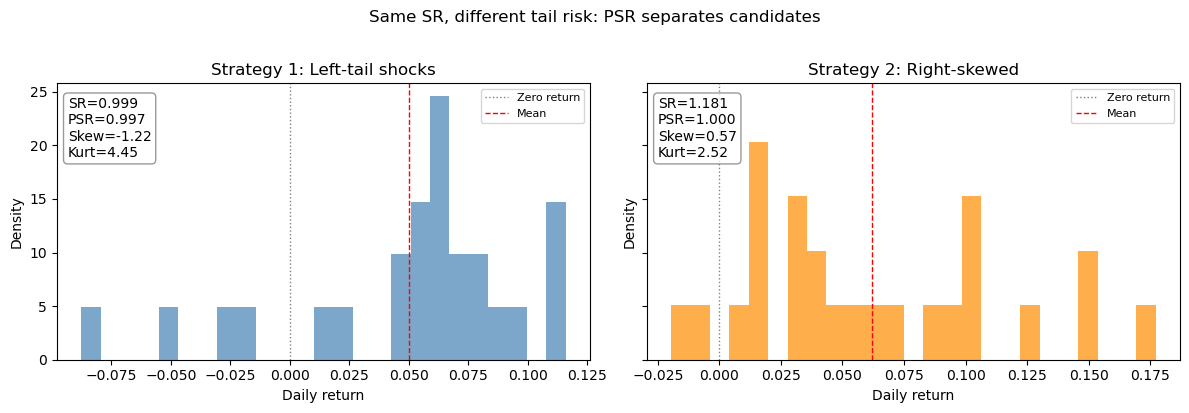

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_data = [
    ('Strategy 1: Left-tail shocks', returns1, sr1, psr1, skew1, kurt1, 'steelblue'),
    ('Strategy 2: Right-skewed', returns2, sr2, psr2, skew2, kurt2, 'darkorange')
]

for ax, (title, data, sr, psr, skew_v, kurt_v, color) in zip(axes, plot_data):
    ax.hist(data, bins=25, density=True, color=color, alpha=0.7)
    ax.axvline(0.0, color='gray', linestyle=':', linewidth=1, label='Zero return')
    ax.axvline(np.mean(data), color='red', linestyle='--', linewidth=1, label='Mean')
    ax.set_title(title)
    ax.set_xlabel('Daily return')
    ax.set_ylabel('Density')
    stats_text = f"SR={sr:.3f}\nPSR={psr:.3f}\nSkew={skew_v:.2f}\nKurt={kurt_v:.2f}"

    ax.text(
        0.02, 0.95, stats_text,
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    )
    ax.legend(loc='upper right', fontsize=8)

fig.suptitle('Same SR, different tail risk: PSR separates candidates', y=1.02)
plt.tight_layout()
plt.show()

Strategy 1 exhibits negative skewness, while Strategy 2 is positively skewed; their kurtosis values differ due to sampling variation. Although the sample SR of Strategy 1 may appear attractive, its PSR (relative to a zero benchmark) can be lower than that of Strategy 2.

The PSR explicitly accounts for the sampling variability of $\widehat{\mathrm{SR}}$, which increases with negative skewness and fat tails. 


Even with only $252$ observations, Strategy 2 can provide a higher probability that the true Sharpe ratio will be positive in the future. The long-run SR ratios (computed across 10 years) help approximate the true ordering of the strategies.


## Multiple Testing and Selection Bias
Quantitative research often evaluates many candidate models on the same dataset through hyperparameter optimization, feature search, and automated strategy generation. As the number of trials increases, the probability of observing at least one high Sharpe ratio from sampling variability rises sharply. Bailey and Lopez de Prado (2014) emphasize that selection bias and in-sample evaluation overfitting can inflate reported performance unless the full search process is disclosed.

A naive out-of-sample test does not resolve this issue because it ignores the number of trials. The expected maximum Sharpe ratio among $N$ independent trials can be large even when the true Sharpe ratio is zero. This motivates the Deflated Sharpe Ratio, which corrects PSR for multiple testing in model selection pipelines.


## Deflated Sharpe Ratio
The Deflated Sharpe Ratio (DSR) adjusts PSR for the number of trials (Bailey and Lopez de Prado, 2014). Suppose $M$ strategies are tested and are not fully independent. We estimate the effective number of independent trials as

$$N \approx \hat{\rho} + (1 - \hat{\rho}) M,$$

where $\hat{\rho}$ is the average pairwise correlation among the strategies.

Let $\widehat{\mathrm{SR}}_1,\ldots,\widehat{\mathrm{SR}}_M$ be the Sharpe ratios of the trials. Denote by $E[\widehat{\mathrm{SR}}]$ and $V[\widehat{\mathrm{SR}}]$ their cross-sectional mean and variance. The expected maximum Sharpe ratio after $N$ independent trials is approximated by

$$E\Big[\max\{\widehat{\mathrm{SR}}_n\}\Big] \approx E[\widehat{\mathrm{SR}}] + \sqrt{V[\widehat{\mathrm{SR}}]}\Big[(1 - \gamma)\, \Phi^{-1}(1 - 1/N) + \gamma\, \Phi^{-1}(1 - e^{-1}/N)\Big],$$

where $\gamma \approx 0.5772$ is the Euler-Mascheroni constant. Denote this quantity by $\widehat{\mathrm{SR}}_0$.

The DSR of the best strategy is the PSR computed relative to $\widehat{\mathrm{SR}}_0$:

$$\widehat{\mathrm{DSR}} = \Phi\!\left(\frac{\widehat{\mathrm{SR}} - \widehat{\mathrm{SR}}_0}{\hat\sigma(\widehat{\mathrm{SR}})}\right).$$

A high DSR indicates that the observed Sharpe ratio is unlikely to have arisen by chance given the number of trials and the return distribution.

The Deflated Sharpe Ratio directly addresses the statistical distortion induced by hyperparameter tuning, feature selection, and automated strategy generation. In effect, it conditions performance inference on the size and dependence structure of the search space explored by an AutoML pipeline. In this sense, DSR plays a role analogous to a multiple-hypothesis correction in large-scale ML experimentation.


## Superior Predictive Ability (SPA) and Data-Snooping
Hansen (2005) proposes the Test for Superior Predictive Ability (SPA) to address data-snooping when many models are compared to a benchmark. The test evaluates whether any candidate model delivers lower expected loss than the benchmark by using standardized loss differentials and a bootstrap-based null distribution. Compared with White's Reality Check, SPA improves power by down-weighting poor models and using a sample-dependent null distribution.

SPA is complementary to PSR and DSR. While PSR and DSR operate at the level of individual candidate models, SPA operates at the level of the entire model selection pipeline. It tests whether any candidate produced by the pipeline delivers statistically superior performance relative to a benchmark, providing benchmark-centric validation and a form of post-selection inference. In ML terms, SPA evaluates whether a search procedure has discovered signal, not merely a lucky model.


### SPA Test Statistic (Summary)
Let $L(\cdot)$ be a loss function (e.g., squared forecast error). For model $k$ and benchmark $\mathrm{BM}$, define the loss differential

$$d_{k,t} = L(y_t, \hat y_{t|t-1}^{\mathrm{BM}}) - L(y_t, \hat y_{t|t-1}^{k}).$$

The null for superior predictive ability is

$$H_0: \max_k E[d_{k,t}] \le 0,$$

which states that no model has lower expected loss than the benchmark. A common SPA test statistic is

$$T_n^{\mathrm{SPA}} = \max_k \frac{\sqrt{n}\,\bar d_k}{\hat\omega_k},$$

where $\bar d_k$ is the sample mean of $d_{k,t}$ and $\hat\omega_k^2$ is a long-run variance estimate, e.g.,

$$\hat\omega_k^2 = \hat\gamma_{k,0} + 2\sum_{\ell=1}^L \left(1 - \frac{\ell}{L+1}\right)\hat\gamma_{k,\ell}.$$

SPA obtains a p-value by comparing $T_n^{\mathrm{SPA}}$ to a bootstrap distribution constructed from stationary resamples of $d_{k,t}$.


In [686]:
import numpy as np
from numpy.random import default_rng

def long_run_variance(x: np.ndarray, lag: int) -> float:
    x = x - x.mean()
    n = len(x)
    gamma0 = np.dot(x, x) / n
    var = gamma0
    for l in range(1, lag + 1):
        gamma = np.dot(x[l:], x[:-l]) / n
        weight = 1 - l / (lag + 1)
        var += 2 * weight * gamma
    return var

def stationary_bootstrap_indices(n: int, p: float, rng: np.random.Generator) -> np.ndarray:
    indices = []
    while len(indices) < n:
        start = rng.integers(0, n)
        block = []
        while True:
            block.append(start)
            if rng.random() < p or len(indices) + len(block) >= n:
                break
            start = (start + 1) % n
        indices.extend(block)
    return np.array(indices[:n])

def spa_test(loss_bm: np.ndarray, loss_alt: np.ndarray, lag: int = 5, p: float = 0.1, B: int = 300, seed: int = 0):
    """
    Toy SPA-style test using a stationary bootstrap.
    loss_bm: shape (n,)
    loss_alt: shape (m, n)
    """
    n = loss_bm.shape[0]
    d = loss_bm - loss_alt  # shape (m, n)
    dbar = d.mean(axis=1)
    omega = np.array([long_run_variance(dk, lag) for dk in d])
    stat = np.max(np.sqrt(n) * dbar / np.sqrt(omega))

    rng = default_rng(seed)
    stats = []
    for _ in range(B):
        idx = stationary_bootstrap_indices(n, p, rng)
        d_star = d[:, idx]
        dbar_star = d_star.mean(axis=1)
        stat_star = np.max(np.sqrt(n) * dbar_star / np.sqrt(omega))
        stats.append(stat_star)
    pval = np.mean(np.array(stats) > stat)
    return stat, pval

# Synthetic example: benchmark vs. 10 alternatives
n = 252 * 2
m = 10
rng = default_rng(123)
eps_bm = rng.normal(0, 1, n)
loss_bm = eps_bm ** 2

loss_alt = []
for k in range(m):
    scale = 0.98 if k < m // 3 else 1.0  # a few slightly better models
    eps = rng.normal(0, scale, n)
    loss_alt.append(eps ** 2)
loss_alt = np.array(loss_alt)

stat, pval = spa_test(loss_bm, loss_alt, lag=5, p=0.1, B=300, seed=42)
stat, pval



(np.float64(0.9003861740121412), np.float64(0.74))

In [687]:
# Function to compute the expected maximum Sharpe ratio across N independent trials
def expected_max_sharpe(mean_sr: float, var_sr: float, num_independent: int) -> float:
    # Euler–Mascheroni constant
    gamma_const = 0.5772156649015328606
    # Quantiles from the standard normal distribution
    term1 = (1 - gamma_const) * norm.ppf(1 - 1 / num_independent)
    term2 = gamma_const * norm.ppf(1 - np.exp(-1) / num_independent)
    return mean_sr + np.sqrt(var_sr) * (term1 + term2)

# Function to compute effective number of independent trials
def effective_num_independent_trials(correlation_matrix: np.ndarray) -> float:
    m = correlation_matrix.shape[0]
    # Average of off-diagonal correlations
    upper_tri_indices = np.triu_indices(m, k=1)
    avg_corr = correlation_matrix[upper_tri_indices].mean()
    return avg_corr + (1 - avg_corr) * m

# Function to compute the Deflated Sharpe Ratio
def deflated_sharpe_ratio(best_sr: float, sr_benchmark: float, gamma3: float, gamma4: float,
                          n: int, sr_array: np.ndarray, correlation_matrix: np.ndarray) -> float:
    # Effective number of independent trials
    N_eff = effective_num_independent_trials(correlation_matrix)
    # Cross-sectional mean and variance of Sharpe ratios
    mean_sr = np.mean(sr_array)
    var_sr = np.var(sr_array, ddof=1)
    # Expected maximum Sharpe ratio among the independent trials
    sr0 = expected_max_sharpe(mean_sr, var_sr, int(max(1, round(N_eff))))
    # Compute the DSR as PSR relative to sr0
    se = standard_error_sharpe(best_sr, gamma3, gamma4, n)
    z = (best_sr - sr0) / se
    return norm.cdf(z)



## Example 2 - Multiple Random Strategies and Deflated Sharpe Ratio
To illustrate multiple testing, we simulate an investment universe of five assets with daily returns drawn from a multivariate normal distribution with modest correlations. We then generate $M=500$ random candidate models by assigning random portfolio weights to the assets each day. Since the weights are random, none of the candidate models has a genuine edge and any impressive Sharpe ratio results from sampling variability.

We compute the Sharpe ratio for each strategy, select the best one, and evaluate it using PSR (relative to zero) and DSR, which adjusts for the number of trials and their correlation structure.


In [688]:
# Parameters for simulation
np.random.seed(123)
num_assets = 5
num_days = 252 * 2  # two years of daily data (~252 trading days per year)
num_strategies = 500  # number of random in-sample evaluations

# Generate synthetic asset returns: multivariate normal with small mean and covariance
asset_means = np.zeros(num_assets)
# Covariance matrix with slight correlations
cov_matrix = 0.05 ** 2 * (0.2 * np.ones((num_assets, num_assets)) + 0.8 * np.eye(num_assets))

# Generate daily returns for all assets
asset_returns = np.random.multivariate_normal(mean=asset_means, cov=cov_matrix, size=num_days)

# Create strategies: for each day, assign random weights that sum to 1
strategies_returns = np.zeros((num_strategies, num_days))
for i in range(num_strategies):
    weights = np.random.dirichlet(alpha=np.ones(num_assets), size=num_days)
    strategies_returns[i] = np.sum(weights * asset_returns, axis=1)

# Compute Sharpe ratios (non-annualized) for each strategy
sr_array = np.array([compute_sr(strategies_returns[i]) for i in range(num_strategies)])

# Identify the strategy with the highest Sharpe ratio
best_idx = np.argmax(sr_array)
best_returns = strategies_returns[best_idx]
best_sr = sr_array[best_idx]

# Compute skewness and kurtosis of the best strategy
best_skew = sample_skewness(best_returns)
best_kurt = sample_kurtosis(best_returns)

# Compute Probabilistic Sharpe Ratio of the best strategy relative to zero benchmark
n_best = len(best_returns)
psr_best = compute_psr(best_sr, sr_benchmark=0.0, gamma3=best_skew, gamma4=best_kurt, n=n_best)

# Compute correlation matrix of strategies' returns to estimate effective independent trials
corr_matrix = np.corrcoef(strategies_returns)

# Compute Deflated Sharpe Ratio
dsr_best = deflated_sharpe_ratio(best_sr, sr_benchmark=0.0, gamma3=best_skew, gamma4=best_kurt,
                                 n=n_best, sr_array=sr_array, correlation_matrix=corr_matrix)

# Summarize results
multi_summary = {
    'Best Strategy Index': best_idx,
    'Best Sharpe Ratio': best_sr,
    'Skewness': best_skew,
    'Kurtosis': best_kurt,
    'PSR (SR* = 0)': psr_best,
    'DSR': dsr_best,
    'Mean SR across strategies': sr_array.mean(),
    'Std SR across strategies': sr_array.std(ddof=1)
}

multi_summary



{'Best Strategy Index': np.int64(316),
 'Best Sharpe Ratio': np.float64(0.05775968559265619),
 'Skewness': np.float64(0.07569351803139264),
 'Kurtosis': np.float64(3.0971104234283953),
 'PSR (SR* = 0)': np.float64(0.9027045212232379),
 'DSR': np.float64(0.5152137961042157),
 'Mean SR across strategies': np.float64(0.0029439134390976383),
 'Std SR across strategies': np.float64(0.020742627889402183)}

### Discussion
In this experiment we generated 500 random strategies, none of which has an edge because the underlying asset returns are mean-zero. Nevertheless, the best strategy among them achieved a relatively high sample Sharpe ratio. The PSR relative to a zero benchmark was also high, suggesting positive skill.

Once we account for the number of trials, the DSR drops substantially. The DSR compares the best Sharpe ratio to the expected maximum Sharpe ratio under the null hypothesis of no skill, using the estimated correlation among strategies to determine the effective number of independent trials. A low DSR indicates that the apparent performance is consistent with a statistical fluke.


## Conclusion and Key Takeaways
PSR and DSR correct inference on Sharpe ratios, but they do not validate the Sharpe ratio as a sufficient descriptor of candidate model quality. They address statistical reliability, not economic robustness; they do not guarantee economic significance or address non-stationarity.

- The Sharpe ratio is an estimator. Its standard error depends on sample size, skewness, and kurtosis (Bailey and Lopez de Prado, 2012).
- PSR converts a Sharpe ratio into a probability of exceeding a benchmark, accounting for track-record length and non-normality.
- Multiple testing inflates the expected maximum Sharpe ratio, making naive comparisons misleading (Bailey and Lopez de Prado, 2014).
- DSR adjusts PSR by using the expected maximum Sharpe ratio across trials as the benchmark, helping distinguish skill from data-mining artifacts.

Suggested workflow for quantitative ML pipelines:
- Use PSR for uncertainty-aware ranking of candidate models.
- Apply DSR to the best-performing model to correct for search-induced inflation.
- Use SPA as a final hypothesis test against a benchmark.
- Reject pipelines that fail SPA, regardless of individual Sharpe ratios.

An open research direction is the integration of PSR- and SPA-style inference directly into AutoML objective functions, enabling search procedures that internalize statistical uncertainty rather than correcting for it ex post.


## References
- Bailey, D. H. and M. Lopez de Prado (2012). "The Sharpe Ratio Efficient Frontier." Journal of Risk. PDF: `papers/The Sharpe Ratio Efficient Frontier.pdf`
- Bailey, D. H. and M. Lopez de Prado (2014). "The Deflated Sharpe Ratio: Correcting for Selection Bias, Backtest Overfitting and Non-Normality." Journal of Portfolio Management. PDF: `papers/The Deflated Sharpe Ratio.pdf`
- Hansen, P. R. (2005). "A Test for Superior Predictive Ability." Journal of Business & Economic Statistics. PDF: `papers/A_Test_for_Superior_Predictive_Ability.pdf`


## Github
Article and code available on [Github](https://github.com/adamd1985/quant_research/blob/main/dont_get_fooled_by_chance.ipynb)

Kaggle notebook available [here]()

Google Colab available [here](https://colab.research.google.com/github/adamd1985/quant_research/blob/main/dont_get_fooled_by_chance.ipynb)


## Media
All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.
